# Colab commands

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/build_model/TrainValidate.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_features_removed.csv /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_labels_removed.csv /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_sources_removed.csv /content
!cp /content/drive/MyDrive/all_removed_weighted_sampler_full_epoch_1000_fold_2.pth /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_features_prices.csv /content
!mkdir /content/models

In [ ]:
!pip install --quiet torchinfo
!pip install --quiet torch_snippets

# Import packages

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter

import torchinfo
from torch_snippets import Report
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from TrainValidate import TrainValidate, create_weighted_sampler

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"

In [3]:
device

'cuda'

# Basic model
## Load datasets

In [4]:
features = pd.read_csv("../datasets/final_features_prices.csv")
labels = pd.read_csv("../datasets/final_labels_removed.csv")

## Creat class for collecting data

In [5]:
class StatusDataset(Dataset):
    def __init__(self, features, labels):
        assert len(features) == len(labels)
        self.features = features
        self.labels = labels

    def __getitem__(self, item):
        features = self.features.to_numpy()[item]
        features = torch.tensor(features).float().to(device)

        labels = self.labels.to_numpy()[item]
        status = torch.tensor([labels[0]]).float().to(device)

        return features, status

    def __len__(self):
        return len(self.features)

In [6]:
temp = StatusDataset(features, labels)
in_features = len(temp[0][0])
in_features

53

## Build the model

In [240]:
class PredictStatus(nn.Module):
    def __init__(self, in_features):
        super(PredictStatus, self).__init__()

        self.hidden = nn.Sequential(nn.Linear(in_features, 256),
                                    nn.BatchNorm1d(256),
                                    nn.Dropout(0.7),
                                    nn.ReLU(),
                                    nn.Linear(256, 512),
                                    nn.BatchNorm1d(512),
                                    nn.Dropout(0.7),
                                    nn.ReLU(),
                                    nn.Linear(512, 1024),
                                    nn.BatchNorm1d(1024),
                                    nn.Dropout(0.8),
                                    nn.ReLU(),
                                    nn.Linear(1024, 256),
                                    nn.BatchNorm1d(256),
                                    nn.Dropout(0.7),
                                    nn.ReLU(),
                                    nn.Linear(256, 64),
                                    nn.BatchNorm1d(64),
                                    nn.Dropout(0.8),
                                    nn.ReLU())
        self.status = nn.Sequential(nn.Linear(64, 1),
                                    nn.Sigmoid())

    def forward(self, x):
        hidden = self.hidden(x)
        out = self.status(hidden)

        return out

In [241]:
model = PredictStatus(in_features)
torchinfo.summary(model, input_size=(1, in_features))

Layer (type:depth-idx)                   Output Shape              Param #
PredictStatus                            [1, 1]                    --
├─Sequential: 1-1                        [1, 64]                   --
│    └─Linear: 2-1                       [1, 256]                  13,824
│    └─BatchNorm1d: 2-2                  [1, 256]                  512
│    └─Dropout: 2-3                      [1, 256]                  --
│    └─ReLU: 2-4                         [1, 256]                  --
│    └─Linear: 2-5                       [1, 512]                  131,584
│    └─BatchNorm1d: 2-6                  [1, 512]                  1,024
│    └─Dropout: 2-7                      [1, 512]                  --
│    └─ReLU: 2-8                         [1, 512]                  --
│    └─Linear: 2-9                       [1, 1024]                 525,312
│    └─BatchNorm1d: 2-10                 [1, 1024]                 2,048
│    └─Dropout: 2-11                     [1, 1024]              

## Data standardization

In [22]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

## Split datasets

In [23]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.1)

## Cross validation

In [357]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13409118067837763408)
epochs = 300

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = StatusDataset(train_feature, train_label)
    val_data = StatusDataset(val_feature, val_label)
    in_features = len(train_data[0][0])

    train_sampler = create_weighted_sampler(train_label["Completed"].values, [0.2, 0.0])
    val_sampler = create_weighted_sampler(val_label["Completed"].values, [0.2, 0.0])

    train_loader = DataLoader(train_data, batch_size=32, shuffle=False, drop_last=True, sampler=train_sampler)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False, drop_last=True, sampler=val_sampler)

    model = PredictStatus(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_validate = TrainValidate(model, nn.BCELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/status_bias_0.2_fold_{}.pth".format(fold))



-------------This is fold 0----------------
EPOCH: 21.832	train_loss: 0.668	(61.67s - 785.74s remaining)

KeyboardInterrupt: 

In [465]:
filename = "models/status_v4_fold_1.pth"

model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()
completed, labels = [], []
test_data = StatusDataset(x_test, y_test)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, drop_last=False)

for data in test_loader:
    x, y = data
    x = x.to("cpu")
    y = y.to("cpu")

    pred_com = model(x)
    pred_com = torch.where(pred_com > 0.5, 1.0, 0.0)
    for item in pred_com.tolist():
        completed.append(item[0])
    for item in y.tolist():
        labels.append(item[0])

pred = pd.DataFrame({"pred_completed": completed, "Truth": labels})

In [466]:
pred

,pred_completed,Truth
0,0.0,0.0
1,0.0,1.0
2,1.0,1.0
3,0.0,1.0
4,1.0,1.0
...,...,...
895,1.0,1.0
896,1.0,0.0
897,1.0,0.0
898,1.0,1.0


[Text(0, 0.5, 'Completed'), Text(0, 1.5, 'Not Completed')]

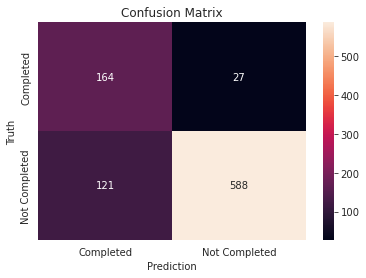

In [467]:
cm = confusion_matrix(pred["pred_completed"], pred["Truth"])
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.title("Confusion Matrix")
ax.xaxis.set_ticklabels(['Completed', 'Not Completed'])
ax.yaxis.set_ticklabels(['Completed', 'Not Completed'])

In [468]:
print("Accuracy: {}".format(accuracy_score(pred["pred_completed"], pred["Truth"])))
print("Recall: {}".format(recall_score(pred["pred_completed"], pred["Truth"])))
print("Precision: {}".format(precision_score(pred["pred_completed"], pred["Truth"])))
print("F1 Score: {}".format(f1_score(pred["pred_completed"], pred["Truth"])))

Accuracy: 0.8355555555555556
Recall: 0.8293370944992948
Precision: 0.9560975609756097
F1 Score: 0.8882175226586102


# Add learning rate scheduler
## Redefine train & validation batch

In [242]:
def train_batch(data, model, loss_fn, optimizer):
    model.train()

    x, y = data
    yhat = model(x)
    loss = loss_fn(yhat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def val_batch(data, model, loss_fn):
    model.eval()

    x, y = data
    yhat = model(x)
    loss = loss_fn(yhat, y)

    return loss.item()

def train(num_epoch, model, loss_fn, optimizer, scheduler, train_loader, val_loader, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    log = Report(num_epoch)

    for epoch in range(num_epoch):
        N = len(train_loader)
        for i, data in enumerate(train_loader):
            train_loss = train_batch(data, model, loss_fn, optimizer)
            log.record(epoch + (i + 1) / N, train_loss=train_loss, end='\r')

        N = len(val_loader)
        for i, data in enumerate(val_loader):
            val_loss = val_batch(data, model, loss_fn)
            log.record(epoch + (i + 1) / N, val_loss=val_loss, end='\r')

        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()
    log.plot()

## Load datasets

In [243]:
features = pd.read_csv("../datasets/final_features_prices.csv")
labels = pd.read_csv("../datasets/final_labels_removed.csv")

## Data standardization

In [244]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

## Cross validation



-------------This is fold 0----------------
EPOCH: 200.000	val_loss: 0.652	(586.63s - 0.00s remaining)g)))

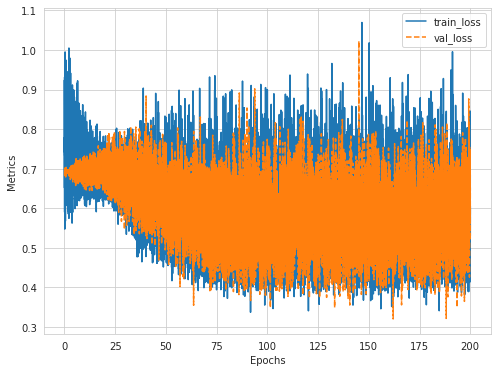



-------------This is fold 1----------------
EPOCH: 200.000	val_loss: 0.577	(586.56s - 0.00s remaining)g)))

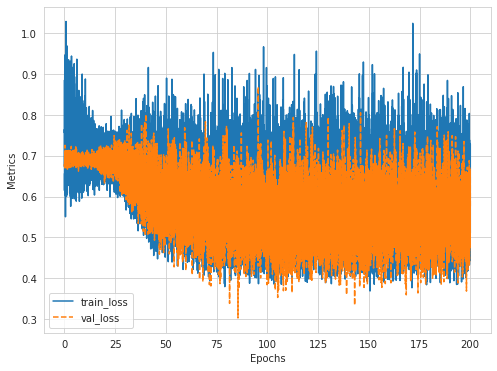



-------------This is fold 2----------------
EPOCH: 200.000	val_loss: 0.567	(542.50s - 0.00s remaining)g)))

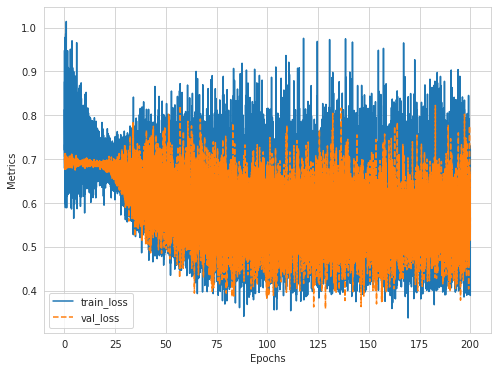



-------------This is fold 3----------------
EPOCH: 200.000	val_loss: 0.455	(536.53s - 0.00s remaining)g)))

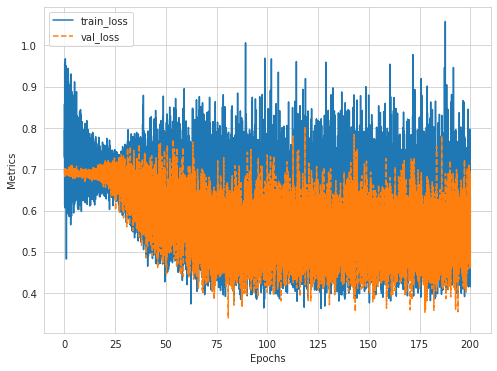



-------------This is fold 4----------------
EPOCH: 200.000	val_loss: 0.400	(536.05s - 0.00s remaining)g)))

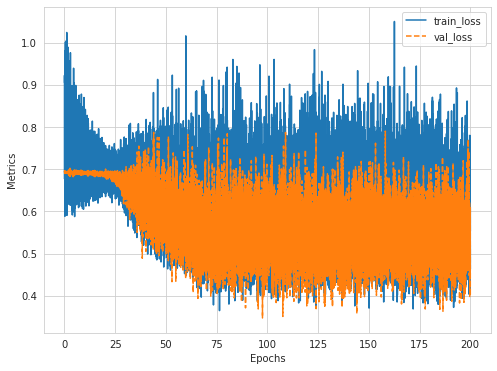

In [246]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
num_epoch = 200

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = StatusDataset(train_feature, train_label)
    val_data = StatusDataset(val_feature, val_label)
    in_features = len(train_data[0][0])

    train_sampler = create_weighted_sampler(train_label["Completed"].values)
    val_sampler = create_weighted_sampler(val_label["Completed"].values)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=False, drop_last=True, sampler=train_sampler)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False, drop_last=True, sampler=val_sampler)

    model = PredictStatus(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCELoss()
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=75, gamma=0.01)

    train(num_epoch, model, loss_fn, optimizer, scheduler, train_loader, val_loader)

    torch.save(model, "models/status_scheduler_fold_{}.pth".format(fold))

# Resnet model
## load datasets

In [ ]:
features = pd.read_csv("../datasets/final_features_prices.csv")
labels = pd.read_csv("../datasets/final_labels_removed.csv")

## Build the model

In [232]:
class PredictStatus(nn.Module):
    def __init__(self, in_features):
        super(PredictStatus, self).__init__()

        self.hidden = nn.Sequential(nn.Linear(in_features, 256),
                                    nn.BatchNorm1d(256),
                                    nn.Dropout(0.7),
                                    nn.ReLU(),
                                    nn.Linear(256, 512),
                                    nn.BatchNorm1d(512),
                                    nn.Dropout(0.7),
                                    nn.ReLU(),
                                    nn.Linear(512, 1024),
                                    nn.BatchNorm1d(1024),
                                    nn.Dropout(0.8),
                                    nn.ReLU(),
                                    nn.Linear(1024, 256),
                                    nn.BatchNorm1d(256),
                                    nn.Dropout(0.7),
                                    nn.ReLU(),
                                    nn.Linear(256, in_features),
                                    nn.BatchNorm1d(in_features),
                                    nn.Dropout(0.8))
        self.status = nn.Sequential(nn.Linear(in_features, 1),
                                    nn.Sigmoid())

    def forward(self, x):
        hidden = self.hidden(x)
        hidden += x
        hidden = nn.ReLU()(hidden)

        out = self.status(hidden)

        return out

In [233]:
model = PredictStatus(51)
torchinfo.summary(model, input_size=(16, 51))

Layer (type:depth-idx)                   Output Shape              Param #
PredictStatus                            [16, 1]                   --
├─Sequential: 1-1                        [16, 51]                  --
│    └─Linear: 2-1                       [16, 256]                 13,312
│    └─BatchNorm1d: 2-2                  [16, 256]                 512
│    └─Dropout: 2-3                      [16, 256]                 --
│    └─ReLU: 2-4                         [16, 256]                 --
│    └─Linear: 2-5                       [16, 512]                 131,584
│    └─BatchNorm1d: 2-6                  [16, 512]                 1,024
│    └─Dropout: 2-7                      [16, 512]                 --
│    └─ReLU: 2-8                         [16, 512]                 --
│    └─Linear: 2-9                       [16, 1024]                525,312
│    └─BatchNorm1d: 2-10                 [16, 1024]                2,048
│    └─Dropout: 2-11                     [16, 1024]             

## Data standardization

In [ ]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

## Split datasets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.1)

## Train the model



-------------This is fold 0----------------
EPOCH: 200.000	val_loss: 0.663	(1173.32s - 0.00s remaining)g)))

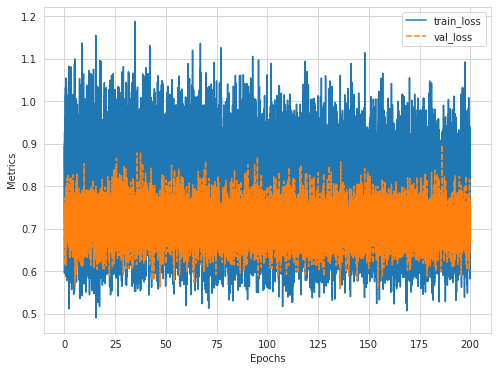



-------------This is fold 1----------------
EPOCH: 1.520	val_loss: 0.663	(12.32s - 1608.37s remaining)g)

KeyboardInterrupt: 

In [239]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
#torch.manual_seed(13409118067837763408)
epochs = 200

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = StatusDataset(train_feature, train_label)
    val_data = StatusDataset(val_feature, val_label)
    in_features = len(train_data[0][0])

    train_sampler = create_weighted_sampler(train_label["Completed"].values)
    val_sampler = create_weighted_sampler(val_label["Completed"].values)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=False, drop_last=True, sampler=train_sampler)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False, drop_last=True, sampler=val_sampler)

    model = PredictStatus(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_validate = TrainValidate(model, nn.BCELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/status_resnet_fold_{}.pth".format(fold))